# Проект Кредитного Скоринга
Версия 08


Вводные. Задача кредитного скоринга по выявлению дефолтных клиентов.  Необходимо разработать и обучить модель, коорая бы выявляла клиентов, которые совершат дефолт. Использовать можно только методы ML. В качестве метрики предложено использовать AUCROC.

Значения столбцов:
- client_id       - идентификатор клиента
- app_date    - дата заявки на кредит
- education       - уровень образования
- sex	            - пол заёмщика
- age	            - возраст заёмщика
- car	            - наличие автомобиля
- car_type        - автомобиль-иномарка
- decline_app_cnt	- количество отказанных прошлых заявок
- good_work       - наличие «хорошей» работы
- score_bki       - скоринговый балл из БКИ
- bki_request_cnt	- количество запросов в БКИ
- region_rating - рейтинг региона
- home_address	- категоризатор домашнего адреса
- work_address	- категоризатор рабочего адреса
- income	        - доход заёмщика
- sna       -   связь заемщика с клиентами банка
- first_time        - давность наличия информации о заемщике
- foreign_passport - наличие загранпаспорта
- default	        - наличие дефолта


Общее замечание.  Работа над задачей носит итеративный характер. В рамках одного ноутбука приходится многократно исполнять одни и те же ячейки без пользы. Принято решение разделить задачу по стадиям:
- Разведывательный анализ данных (EDA)
- Разработка признаков (FE)
- Подбор гиперпараметров (HPT)
- Формирование тестовых данных для соревнований на kaggle (KC).

Первые три шага будут выполнены локально. В облако kaggle будет загружена только последний ноутбук или вообще только конечные данные.

**Это первая из трех рабочих книг.**

In [22]:
from pandas import Series
import pandas as pd
import pandas_profiling
import numpy as np
from datetime import datetime, date
import time, gc

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN
from sklearn.feature_selection import f_classif, mutual_info_classif

from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, RobustScaler, normalize
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import ExtraTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import auc, roc_auc_score, roc_curve, accuracy_score, matthews_corrcoef, precision_score, recall_score, f1_score

import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

In [23]:
RANDOM_SEED = 42

 ## Вспомогательные функции

In [24]:
#  Функция расчета G-score
#  a - выявление клиентов группы 0
#  b - выявление клиентов группы 1
#  g_score - среднее двух выявлений, ограниченных сверху 1
def g_score(cm): # confusion_matrix на вход
    a = cm[0,0]/(cm[0,0]+cm[0,1])
    b = cm[1,1]/(cm[1,0]+cm[1,1])
    return ( min(a,1) + min(b,1) )/2.0, a, b

In [25]:
def print_metrics(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    cmdf = pd.DataFrame(cm, index = ['actual 0', 'actual 1'], columns = ['detected 0', 'detected 1'])
    print(cmdf)
    g,a,b = g_score(cm)
    print(' ',
        'Accuracy:      {:.4f}'.format(accuracy_score(y_test, y_pred)),
#        'f1_score: {:.4f}'.format(f1_score(y_test, y_pred)),
        'Recall:        {:.4f}'.format(recall_score(y_test, y_pred)),
        'Precision:     {:.4f}'.format(precision_score(y_test,y_pred)),
        'MCC:           {:.4f}'.format(matthews_corrcoef(y_test, y_pred)),
        'AUCROC:        {:.4f}'.format(roc_auc_score(y_test,y_pred)),
        'Detection 0:   {:.4f}'.format(a),
        'Detection 1:   {:.4f}'.format(b),
        'Total G-Score: {:.4f}'.format(g),
        sep="\n")


In [26]:
def init_metrics(name=None):
    lm = ['Recall', 'Selectivity', 'FNR', 'FPR', 'Bal.Error', 'AUCROC', 'f1-score', 'MCC']
    return pd.Series(data=np.zeros(len(lm)),index=lm,name=name, dtype='float64')

In [27]:
def get_metrics(y_test, y_pred, probs, metr ):
    # v = init_metrics(name)
    cm = confusion_matrix(y_test, y_pred)
    TN = cm[0,0]; FP = cm[0,1]; FN = cm[1,0]; TP = cm[1,1]

    # v['Accuracy']=  round(accuracy_score(y_test, y_pred),4)
    metr['Recall'] +=    round(recall_score(y_test, y_pred, zero_division=0),4)
    metr['Selectivity'] += round(( TN/(TN+FP)),4)
    metr['FPR'] += round(( FP/(TN+FP)),4)
    metr['FNR'] += round(( FN/(TP+FN)),4)
    metr['Bal.Error'] += round( ((FN/(TP+FN))+(FP/(TN+FP)))/2 ,4)
    # v['Precision']= round(precision_score(y_test, y_pred, zero_division=0),4)
    metr['f1-score' ] += round(f1_score(y_test, y_pred, zero_division=0),4)
    metr['MCC'] +=       round(matthews_corrcoef(y_test, y_pred),4)
    metr['AUCROC'] +=    round(roc_auc_score(y_test, probs),4)
    return metr

In [28]:
# Evaluate basic model
def eval_basic_models(df, osm='None', list_models=[] ):
    # OSM = oversamplint method
    # train_df = df.drop(['client_id'], axis=1)
    was = time.perf_counter()   # замер времени работы
    _ = gc.collect()            #  принудительный сбор мусора
    X = df.drop(['default'], axis=1).values
    y = df['default'].values

    # RandomOverSampler, SMOTE, ADASYN
    oversamplers = {'RanOS': RandomOverSampler(),'SMOTE': SMOTE(),'ADASYN': ADASYN()}



    # X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.20, random_state=RANDOM_SEED )


    models = {
    # models with default settings
    'LogReg'  : LogisticRegression(max_iter=1000, n_jobs=-1), # fix ConvergenceWarning
    'DecTree' : DecisionTreeClassifier(),
    'ExtTree' : ExtraTreeClassifier(),
    'AdaBst'  : AdaBoostClassifier(n_estimators=100), # количество из демо примера
    'Bagg'    : BaggingClassifier( n_jobs=-1),
    'ExtEns'  : ExtraTreesClassifier(n_jobs =-1),
    'GradBst' : GradientBoostingClassifier(n_estimators=100),  # количество из примера
    'RanFrst' : RandomForestClassifier(n_jobs=-1) }

    if len(list_models) == 0:
        list_models = models.keys()

    metrics = init_metrics('E')   # пустышка для работы concat
    print('Model:', end=' ')

    for mname in list_models:
        # mname = '{}'.format(model).split('(')[0]
        print(mname, end=', ')
        metr=init_metrics(mname)
        #  Набор данных несбалансирован. Поэтому StratifiedKFold
        skf = StratifiedKFold(n_splits=5) # random_state=RANDOM_SEED) - для случая перетасовки
        for train_index, test_index in skf.split(X, y):
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]
            # Поскольку данные несбалансированные, можем выбрать увеличение количества меньшего класса с помощью
            # того или иного алгоритма
            if osm != 'None':
                sampler = oversamplers[osm]
                X_res, y_res = sampler.fit_resample(X_train, y_train)
            else:
                X_res = X_train; y_res = y_train

            models[mname].fit(X_res, y_res)
            y_pred = models[mname].predict(X_test)
            probs = models[mname].predict_proba(X_test)
            # probs = probs[:,1]
            # zero_division=0 to fix zero division Warning
            # print('Results for:', model)
            metr = get_metrics(y_test, y_pred, probs[:,1], metr )
            # конец цикла кроссвалиадции
        for k in metr.keys():
            metr[k] /= 5  # успеднение накопленных значений метрик
        metrics = pd.concat([metrics, metr], axis=1)
    print('done. {:.4f} sec'.format(time.perf_counter() - was))
    return metrics.drop(['E'],axis=1)

In [29]:
# Построение линейных графиков для сравнения моделей.
# Допустимо несколько линий одновременно
def compare_models_plot(assesment, metrics, tlt):
    cols = assesment.columns
    plt.figure(figsize = (20,5))
    for m in metrics:
        plt.plot(cols, [assesment.loc[m,c] for c in cols], label = m )
    plt.title(tlt, fontsize=14)
    plt.legend(loc='best')
    plt.show();

In [30]:
# Построение графика из столбиков для сравнения моделей.
# Допустима только одна метрика.
def compare_models_bar(assesment, metric, tlt):
    cols = assesment.columns
    plt.figure(figsize = (20,4), frameon=False)
    plt.bar(cols,[assesment.loc[metric,c] for c in cols], width = 0.6)
    plt.title(tlt, fontsize=14)
    plt.show();

In [31]:
# Построение линейных графиков для сравнения всех сценариев обработки и классификации.
# Допустимо только одна метка
def compare_scenarios_plot(assesments, metric, tlt):  #Multiple assesment, single metric
    plt.figure(figsize = (20,5))
    for nm, ast in assesments.items():
        cols = ast.columns
        plt.plot(cols, [ast.loc[metric,c] for c in cols], label = nm )
    plt.title(tlt, fontsize=14)
    plt.legend(loc='best')
    plt.show();

In [32]:
# Построение линейных графиков для сравнения отдельных сценариев.
# Допустимо только одна метка
def compare_some_scenarios_plot(scenarios, assesments, metric, tlt):  #Multiple assesment, single metric
    plt.figure(figsize = (20,5))
    for nm in scenarios:
        ast = assesments[nm]
        cols = ast.columns
        plt.plot(cols, [ast.loc[metric,c] for c in cols], label = nm )
    plt.title(tlt, fontsize=14)
    plt.legend(loc='best')
    plt.show();

In [33]:
# Инициализация вектора инфо о выбросах
def init_surge_info(name=None):
    r = ['Lo otl %', 'Lo outlays', 'Lo hurdle', 'Q1', 'Median', 'Q3', 'Hi hurdle', 'Hi outlays', 'Hi otl %', 'IQR']
    return pd.Series(data=None,index=r,name=name, dtype='float64')

In [34]:
# сбор инфо по выбросам
def collect_surge_info(data, num_cols):
    surge_info = init_surge_info('E')
    total_q = data.shape[0]
    for col in num_cols:
        si = init_surge_info(col)
        si['Median'] = data[col].median()
        si['Q1'] = data[col].quantile(0.25)
        # if np.isnan(si['Q1']):
        #    si['Q1'] = 0
        si['Q3'] = data[col].quantile(0.75)
        # if np.isnan(si['Q3']):
        #    si['Q3'] = 0
        si['IQR'] = si['Q3'] - si['Q1']
        si['Lo hurdle'] = si['Q1'] - 1.5 * si['IQR']
        si['Hi hurdle'] = si['Q3'] + 1.5 * si['IQR']
        si['Lo outlays'] = data.loc[(data[col]<si['Lo hurdle']),col].count()
        si['Lo otl %'] = si['Lo outlays'] / total_q
        si['Hi outlays'] = data.loc[(data[col]>si['Hi hurdle']),col].count()
        si['Hi otl %'] = si['Hi outlays'] / total_q
        # metrics = pd.concat([metrics, m], axis=1)
        surge_info = pd.concat([surge_info,si], axis=1)
        #    if fix :
        # ограничение выдающихся по уровню
        #        data[col] = np.where(data[col] > si['Hi hurdle'], si['Hi hurdle'] , data[col])
        #        data[col] = np.where(data[col] < si['Lo hurdle'], si['Lo hurdle'] , data[col])
    return surge_info.drop(['E'], axis =1)

## Exploratory Data Analysis

In [35]:
data = pd.read_csv('train.csv')
data.shape

(73799, 19)

In [36]:
data.head()

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default
0,25905,01FEB2014,SCH,M,62,Y,Y,0,0,-2.008753,1,50,1,2,18000,4,1,N,0
1,63161,12MAR2014,SCH,F,59,N,N,0,0,-1.532276,3,50,2,3,19000,4,1,N,0
2,25887,01FEB2014,SCH,M,25,Y,N,2,0,-1.408142,1,80,1,2,30000,1,4,Y,0
3,16222,23JAN2014,SCH,F,53,N,N,0,0,-2.057471,2,50,2,3,10000,1,3,N,0
4,101655,18APR2014,GRD,M,48,N,N,0,1,-1.244723,1,60,2,3,30000,1,4,Y,0


In [37]:
data_profile =  data.profile_report()
data_profile.to_file("scoring_data_review0.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

#### Ссылка на  **[обзор](./scoring_data_review0.html)**.


Текстовый столбец:  app_date'

Бинарные переменные: sex', car', car_type',  good_work, foreign_passport', default

Категориальные переменные: education', home_address, work_address, region_rating, sna, first_time

Количественные переменные: income, bki_request_cnt, decline_app_cnt, age, score_bki

Наличие ' означает необходимость преобразования из текстовой формы в численную.


Есть сильная попарная корреляция следующих переменных:

- car и car type,
- home-address и work_address,
- sna и first time,

Отчет из pandas_profile хорош. Есть смысл его использовать чаще, и даже в рамках данного проекта.

In [38]:
classes=data['default'].value_counts()
print('Class 0: {} items,'.format(classes[0]), 'Class 1: {} items,'.format(classes[1]),  'Ratio {:.2f}:1'.format(classes[0]/classes[1]))

Class 0: 64427 items, Class 1: 9372 items, Ratio 6.87:1


Данные довольно сильно несбалансированные по классам. Дефолтных заемщиков намного меньше.

In [39]:
data.isna().sum()

client_id             0
app_date              0
education           307
sex                   0
age                   0
car                   0
car_type              0
decline_app_cnt       0
good_work             0
score_bki             0
bki_request_cnt       0
region_rating         0
home_address          0
work_address          0
income                0
sna                   0
first_time            0
foreign_passport      0
default               0
dtype: int64

Есть пропуски в одном столбце education.

## Data Cleaning and Preparation

### Разбор даты

Переменная app_date закодирована в текстовой форме. Ее необходимо преобразовать в численную, понятную алгоритмам классификации. Имеет смысл сразу сделать новые признаки. Добавляю сезонные признаки - день недели, день месяца, месяц, а также дату в Григ.календаре (минус начало наблюдений). Все данные за 2014 год - поэтому без признака года.

In [40]:
# обработка даты
def parse_date(data):
    data['app_date'] = data['app_date'].apply(lambda s: datetime.strptime(s,'%d%b%Y').date() )
    min_app_date = data['app_date'].min().toordinal()
    data['app_weekday'] = data['app_date'].apply(lambda d: d.isoweekday())
    data['app_day'] = data['app_date'].apply(lambda d: d.day)
    data['app_month'] = data['app_date'].apply(lambda d: d.month)
    # устранил создание переменной, на более поздних этапах выяснилсь ее незначительность
    # data['app_date_ord'] = data['app_date'].apply(lambda d: d.toordinal()-min_app_date)
    return data

In [41]:
data = parse_date(data)

In [42]:
print('Данные с ', data['app_date'].min(), 'по', data['app_date'].max() )

Данные с  2014-01-01 по 2014-04-30


Проверка взаимной корреляции новых переменных.

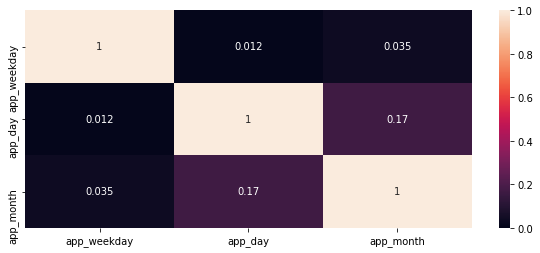

In [43]:
date_cols = ['app_weekday', 'app_day', 'app_month']
plt.figure(figsize=(10, 4))
sns.heatmap(data[date_cols].corr().abs(), vmin=0, vmax=1, annot = True);

В ранних версиях рабочей книги наблюдалась сильная корреляция между app_month и app_date_ord. Сейчас этот признак не создается.

In [44]:
# data = data.drop(['app_date_ord', 'app_date'], axis=1)
# data.head(3)

Добавлены новые поля категориальных признаков - app_weekday, app_day, app_month.

Уточненная структура набора данных:

Бинарные переменные: sex, car, car_type,  good_work, foreign_passport, default

Категориальные переменные: _education_, home_address, work_address, app_weekday, region_rating, sna, first_time, app_day, app_month

Количественные переменные: income, bki_request_cnt, decline_app_cnt, age, score_bki

Кандидат на исключение: app_date_ord

### Анализ количественных переменных

In [45]:
num_cols = ['income', 'bki_request_cnt', 'decline_app_cnt', 'age', 'score_bki']

In [46]:
collect_surge_info(data,num_cols)

,income,bki_request_cnt,decline_app_cnt,age,score_bki
Lo otl %,0.000000,0.000000,0.000000,0.0,0.000705
Lo outlays,0.000000,0.000000,0.000000,0.0,52.000000
Lo hurdle,-22000.000000,-4.500000,0.000000,3.0,-3.294088
Q1,20000.000000,0.000000,0.000000,30.0,-2.259534
Median,30000.000000,1.000000,0.000000,37.0,-1.920823
Q3,48000.000000,3.000000,0.000000,48.0,-1.569831
Hi hurdle,90000.000000,7.500000,0.000000,75.0,-0.535277
Hi outlays,4695.000000,1755.000000,12585.000000,0.0,299.000000
Hi otl %,0.063619,0.023781,0.170531,0.0,0.004052
IQR,28000.000000,3.000000,0.000000,18.0,0.689703


В количественных переменных, кроме возраста, довольно много выбросов. Тяжелый хвост у распределения income и bki_request_cnt. Столбец decline_app_cnt просто состоит из одних выбросов.

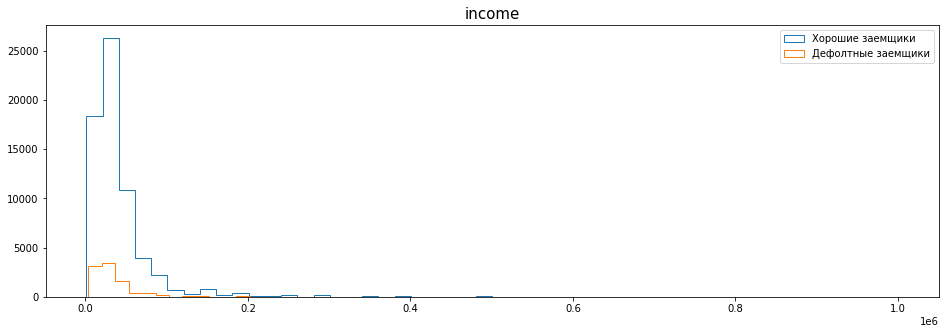

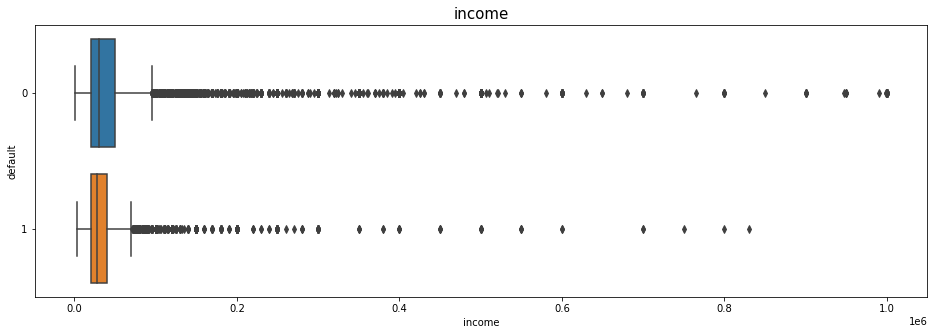

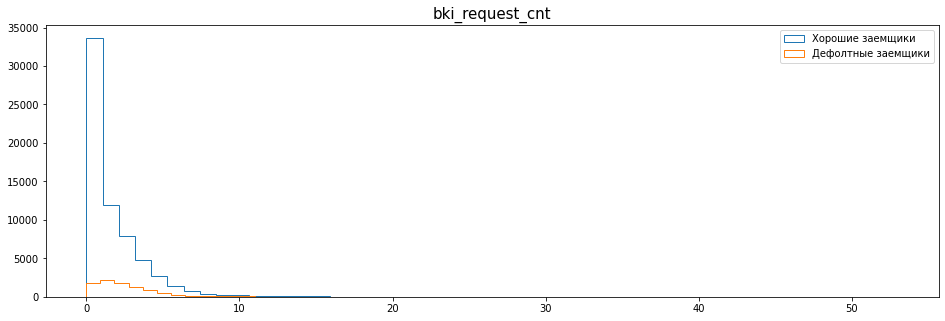

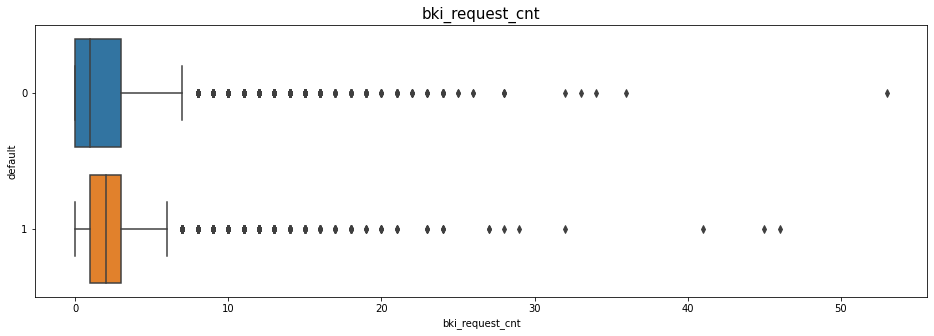

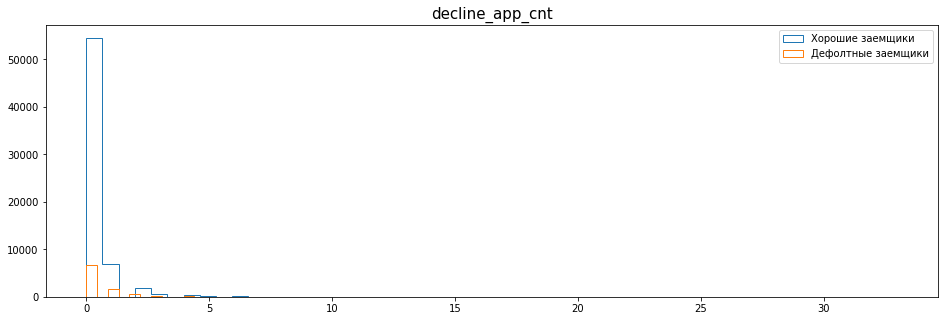

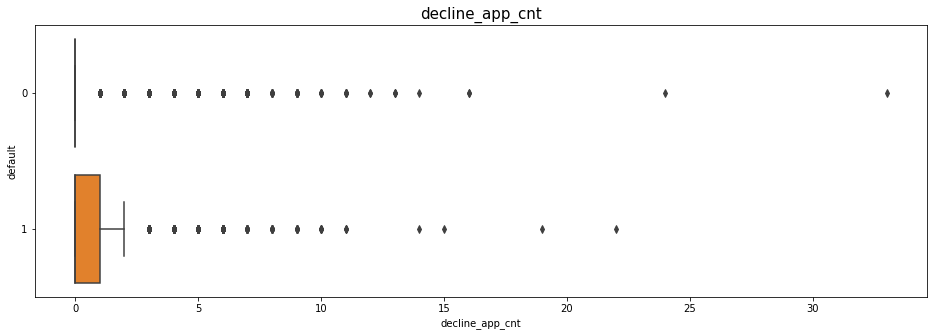

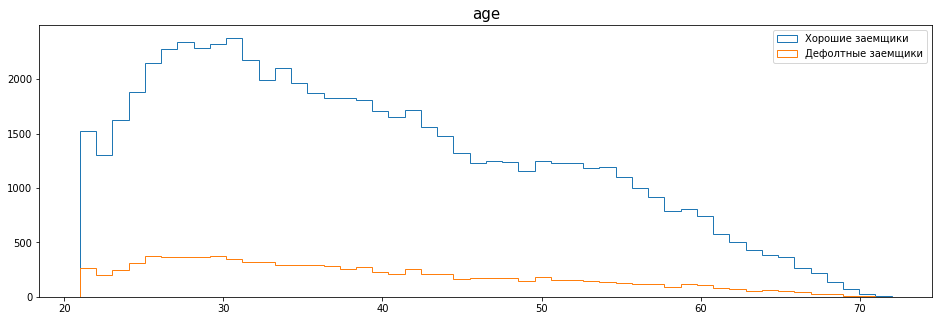

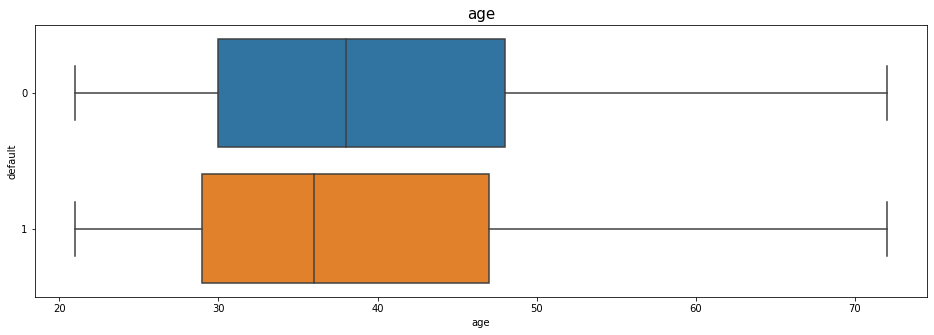

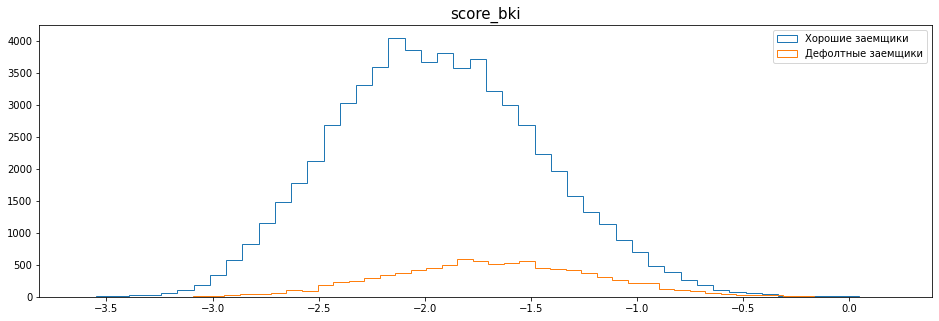

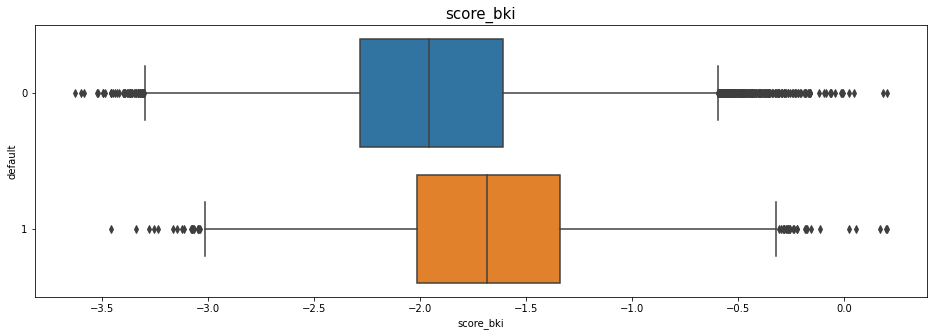

In [47]:
for i in num_cols:
    plt.figure(figsize=(16, 5))
    plt.hist(data.loc[data.default==0][i], bins=50, histtype='step', label='Хорошие заемщики')
    plt.hist(data.loc[data.default==1][i], bins=50, histtype='step', label='Дефолтные заемщики')
    plt.title(i, fontsize =15)
    plt.legend(loc='best');
    plt.figure(figsize = (16,5))
    sns.boxplot(x= i, y = 'default', data=data, orient='h')
    plt.title(i, fontsize=15)
    plt.show();

Требуется преобразование формы нескольким переменным - income, bki_request_cnt, decline_app_cnt. Попробую логарифмировать эти переменные.


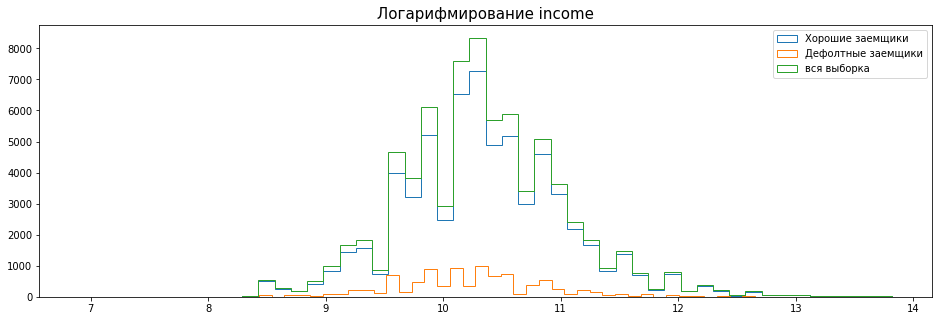

In [48]:
c = 1
i = 'income'
nn = 'log_'+i
data[nn] = np.log(data['income']+c)
plt.figure(figsize=(16, 5))
plt.hist(data.loc[data.default==0][nn], bins=50, histtype='step', label='Хорошие заемщики')
plt.hist(data.loc[data.default==1][nn], bins=50, histtype='step', label='Дефолтные заемщики')
plt.hist(data[nn], bins =50, histtype = 'step', label = 'вся выборка')
plt.title('Логарифмирование '+i, fontsize =15)
plt.legend(loc='best');

In [49]:
collect_surge_info(data,['log_income'])

,log_income
Lo otl %,0.008062
Lo outlays,595.000000
Lo hurdle,8.590378
Q1,9.903538
Median,10.308986
Q3,10.778977
Hi hurdle,12.092136
Hi outlays,1172.000000
Hi otl %,0.015881
IQR,0.875440


Переменную log_income вполне разумно использовать в логарифмированном виде. После логарифмирования у нее появился левый хвост и значительно уменьшился правый.
Логарифмирование ничего не дало для признаков счетчиков запросов в БКИ и отказов.

Возникает гипотеза, что целесообразно проанализировать распределение с устранением нулевых значений.

In [50]:
bki_req = data.loc[data.bki_request_cnt!=0]['bki_request_cnt']
bki_req.quantile(q=[0.25,0.5,0.75,0.95,0.99])

0.25     1.0
0.50     2.0
0.75     3.0
0.95     6.0
0.99    11.0
Name: bki_request_cnt, dtype: float64

Переменную bki_req_cnt было бы интересно преобразовать в категориальную с диапазонами значений 0, 1..2, 2..6, 6+
Если не преобразовывать, то можно ограничить хвост распределения на уровне 10,11.

In [51]:
dec_cnt = data.loc[data.decline_app_cnt!=0]['decline_app_cnt']
dec_cnt.quantile(q=[0.25,0.5,0.75,0.95,0.99])

0.25    1.0
0.50    1.0
0.75    2.0
0.95    4.0
0.99    6.0
Name: decline_app_cnt, dtype: float64

Переменную decline_app_cnt было бы интересно преобразовать в категориальную с диапазонами значений 0, 1, 2..4, 4+
Если не преобразовывать, то можно ограничить хвост распределения на уровне 5,6.

In [52]:
data = data.drop([ 'log_income'], axis = 1)
data.columns

Index(['client_id', 'app_date', 'education', 'sex', 'age', 'car', 'car_type',
       'decline_app_cnt', 'good_work', 'score_bki', 'bki_request_cnt',
       'region_rating', 'home_address', 'work_address', 'income', 'sna',
       'first_time', 'foreign_passport', 'default', 'app_weekday', 'app_day',
       'app_month'],
      dtype='object')

 Выводы:
 - income - тяжелый правый хвост, дефолтные заемщики имеют чуть меньший средний доход, хорошо логарифмируется и распределение "исправляется"
 - bki_request_cnt - тяжелый правый хвост, у дефолтных заемщиков в среднем больше обращений в БКИ, можно преобразовать в категориальную с диапазонами значений 0, 1..2, 2..6, 6+ или ограничить на уровне 10-11 запросов.
 - decline_app_cnt - тяжелый правый хвост, у дефолтных заемщиков заметное количество отказов в кредите, можно преобразовать в категориальную с диапазонами значений 0, 1, 2..4, 4+, или ограничить хвост на уровне 5-6 отказов в кредите. 
 - age - широкое неравномерное распределение с модой слева, дефолтные заемщики чуточку моложе, преобразовать количественную переменную в категориальную - до 30, 30..40, 40..50, 50..60, 60..
 - score_bki - похоже на нормальное распреедение, заметна разница у нормальных и дефолтных заемщиков


**Анализ взаимосвязи возраста и других показателей**

In [53]:
ages = list(np.sort(data['age'].unique()))
inc_age = dict()
for ag in ages:
    mean_i = data.loc[data.age==ag].income.mean()
    std_i = data.loc[data.age==ag].income.std()
    min_i = data.loc[data.age==ag].income.min()
    max_i = data.loc[data.age==ag].income.max()
    ct = data.loc[data.age==ag].income.count()
    mnr = data.loc[data.age==ag].bki_request_cnt.mean()
    sgr = data.loc[data.age==ag].bki_request_cnt.std()
    mxr = data.loc[data.age==ag].bki_request_cnt.max()
    mir = data.loc[data.age==ag].bki_request_cnt.min()
    # Train data only !!!!
    dfr = data.loc[data.age==ag].default.sum()
    inc_age[ag] = [ct, mean_i, std_i, min_i, max_i, mnr, sgr, mir, mxr, dfr/ct ]
stat_cols = ['population', 'mean_inc', 'std_inc', 'min_inc', 'max_inc', 'mean_req','std_req', 'min_req', 'max_req', 'def_rate']

In [54]:
age_stat=pd.DataFrame(data=inc_age,index=stat_cols).transpose()
age_stat.head()
# При необходимости можно сохранить для последующего использования

,population,mean_inc,std_inc,min_inc,max_inc,mean_req,std_req,min_req,max_req,def_rate
21,849.0,27370.612485,12620.034017,1700.0,120000.0,0.935218,1.245481,0.0,12.0,0.144876
22,937.0,30451.386339,17136.374789,3000.0,200000.0,1.598719,1.945057,0.0,26.0,0.147279
23,1509.0,32363.431412,18349.411026,5000.0,180000.0,1.649437,1.822995,0.0,15.0,0.134526
24,1873.0,33980.425521,25012.105239,2400.0,550000.0,1.693006,2.015760,0.0,21.0,0.132408
25,2202.0,35760.502725,29083.577168,1000.0,600000.0,1.807902,1.963055,0.0,28.0,0.143052


На этапе FE можно попробовать сконструировать новые признаки - средний доход для возвраста и относительное количество запросов в БКИ для возраста.

Доля невозвратов по возрасту практически неизменна - что свидетельствует об искусной политике кредитования в Банке. Добавлять ее нет смысла.


**Корреляция**

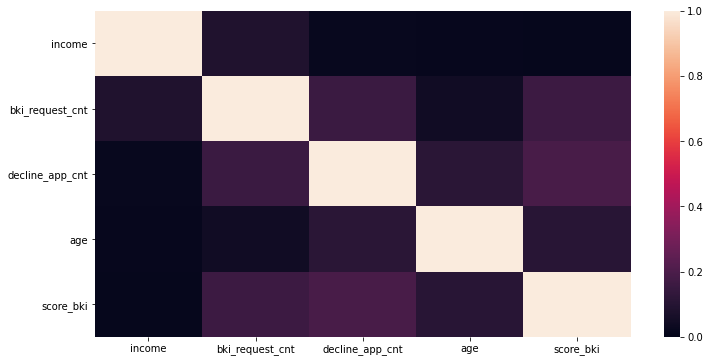

In [55]:
plt.figure(figsize=(12, 6))
sns.heatmap(data[num_cols].corr().abs(), vmin=0, vmax=1);

Количественные переменные практически независимы друг от друга.

**Оценка значимости количественных переменных**

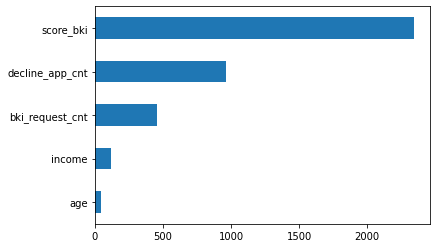

In [56]:
imp_num_col = pd.Series(f_classif(data[num_cols], data['default'])[0], index = num_cols)
imp_num_col.sort_values(inplace = True)
imp_num_col.plot(kind = 'barh');

После добавления данных, важность сменилась. Новым самым важным признаком стал рейтинг БКИ. На этом фоне возраст выглядит не очень важным. Можно попробовать поднять важность  переменных decline_app_cnt и bki_request_cnt за счет добавления признаков среднего для возраста соответствующего количества запросов и отказов.

## Преобразование и анализ категориальных и бинарных переменных

**Преобразование переменных**

Преобразование бинарных переменных из текстовой кодировки в численную.

In [57]:
def binarisation_chars(data):
    data['sex'] = data['sex'].apply(lambda x: (1 if x== 'M' else 0))
    data['car'] = data['car'].apply(lambda x: (1 if x== 'Y' else 0))
    data['car_type'] = data['car_type'].apply(lambda x: (1 if x== 'Y' else 0))
    data['foreign_passport'] = data['foreign_passport'].apply(lambda x: (1 if x== 'Y' else 0))
    # data.head()
    return data

В категориальной переменной education есть пропуски. После заполнения модой, она будет разобрана дважды - в упорядоченный категориальный столбец и набор индексов.  Разбор в набор индексов на стадию FE.

In [58]:
def categorisation_education(data):
    # filling missing values
    edu_vals = data['education'].value_counts()
    # edu_vals
    data['education'].fillna(value=edu_vals.index[0], inplace=True)
    # translating str education to num categories
    edu_cat = {'UGR':2, 'SCH':1, 'GRD':3, 'PGR':4, 'ACD':5} #полагаю, что ugr = неоконченное высшее
    data['educ_cat'] = data['education'].apply(lambda x: edu_cat[x])
    # data.head(3)
    return data

Рейтинг региона представлен двузначным числом кратным десяти. Целесообразно сократить порядок числа в рейтинге.

In [59]:
def region_clean(data):
    # сжатие рейтинга региона до одной десятичной цифры
    data['reg_rate'] = np.rint(data['region_rating']/10).astype(int)
    data = data.drop(['region_rating'], axis=1 )
    return data

In [60]:
data = binarisation_chars(data)
data = categorisation_education(data)
data = region_clean(data)
data.columns

Index(['client_id', 'app_date', 'education', 'sex', 'age', 'car', 'car_type',
       'decline_app_cnt', 'good_work', 'score_bki', 'bki_request_cnt',
       'home_address', 'work_address', 'income', 'sna', 'first_time',
       'foreign_passport', 'default', 'app_weekday', 'app_day', 'app_month',
       'educ_cat', 'reg_rate'],
      dtype='object')

In [61]:
data.head()
# сохраняю данные после преобразований для дальнейшего использования
# data.to_csv('Scoring05.csv')

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,...,income,sna,first_time,foreign_passport,default,app_weekday,app_day,app_month,educ_cat,reg_rate
0,25905,2014-02-01,SCH,1,62,1,1,0,0,-2.008753,...,18000,4,1,0,0,6,1,2,1,5
1,63161,2014-03-12,SCH,0,59,0,0,0,0,-1.532276,...,19000,4,1,0,0,3,12,3,1,5
2,25887,2014-02-01,SCH,1,25,1,0,2,0,-1.408142,...,30000,1,4,1,0,6,1,2,1,8
3,16222,2014-01-23,SCH,0,53,0,0,0,0,-2.057471,...,10000,1,3,0,0,4,23,1,1,5
4,101655,2014-04-18,GRD,1,48,0,0,0,1,-1.244723,...,30000,1,4,1,0,5,18,4,3,6


### Анализ категориальных переменных

In [62]:
cat_cols = ['educ_cat', 'home_address', 'work_address', 'app_weekday', 'reg_rate', 'sna', 'first_time', 'app_day', 'app_month']
short_cat_cols = ['educ_cat', 'home_address', 'work_address', 'reg_rate', 'sna', 'first_time']

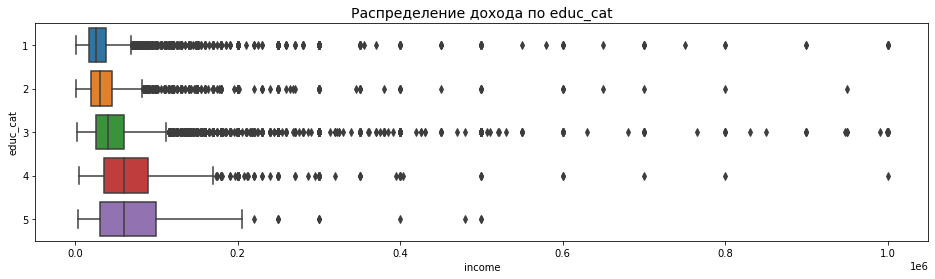

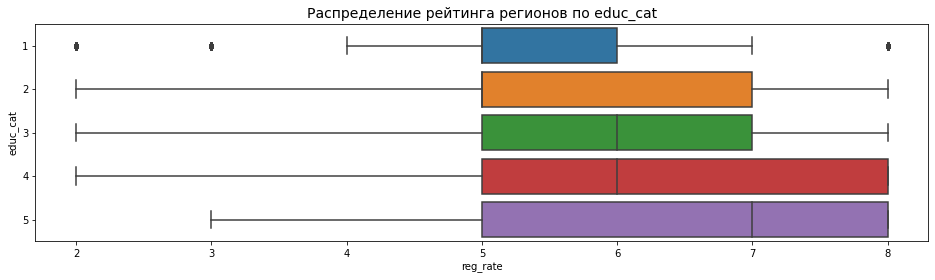

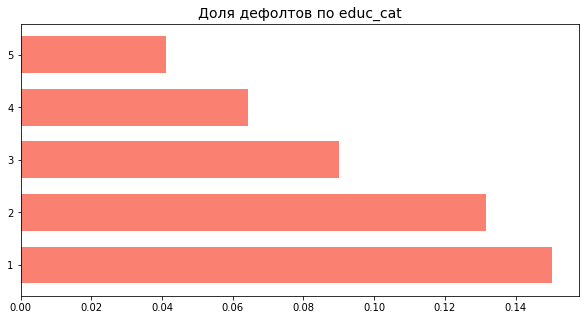

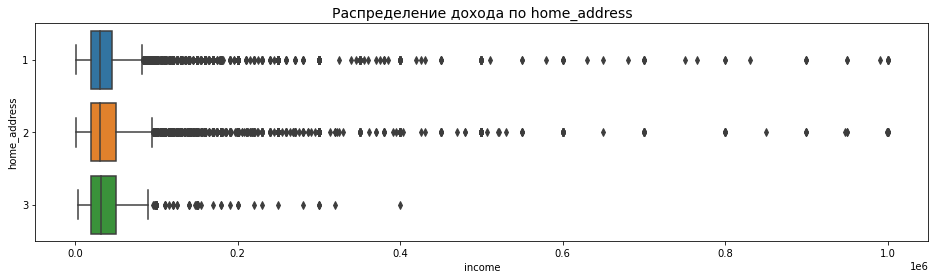

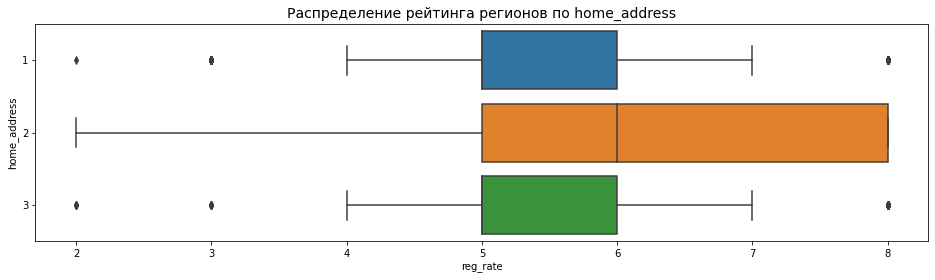

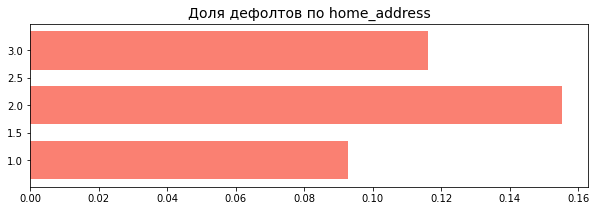

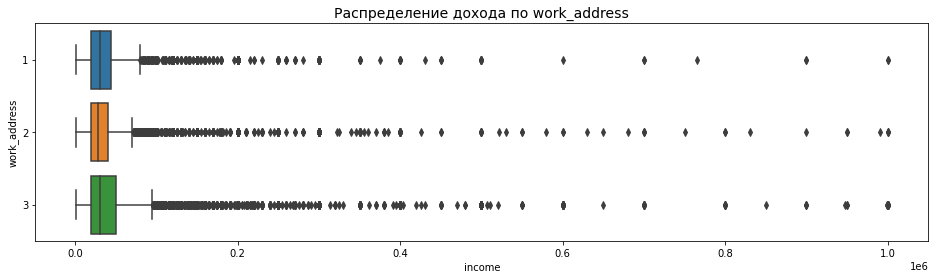

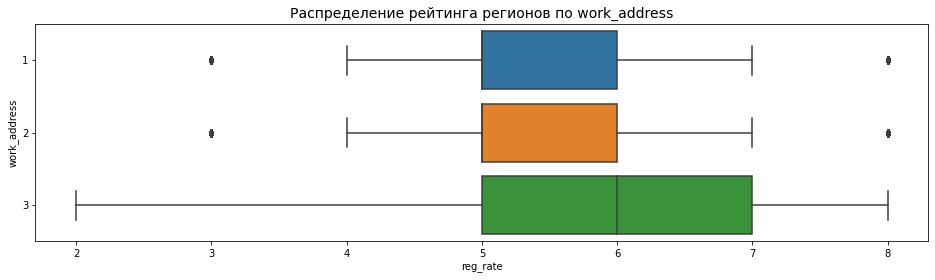

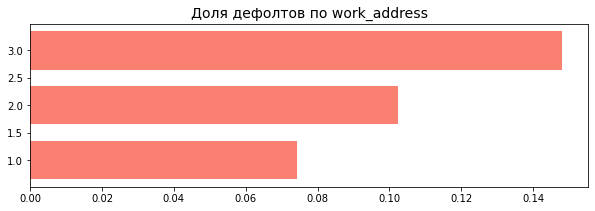

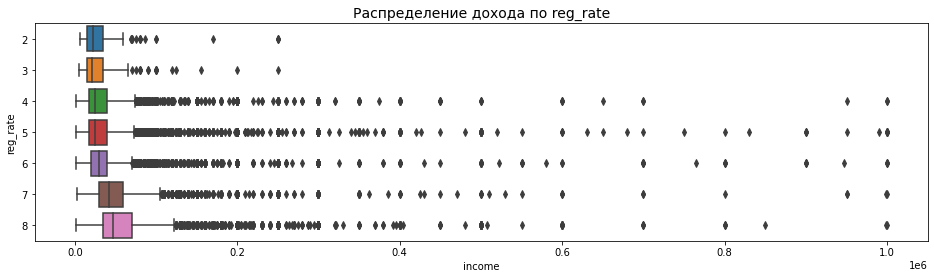

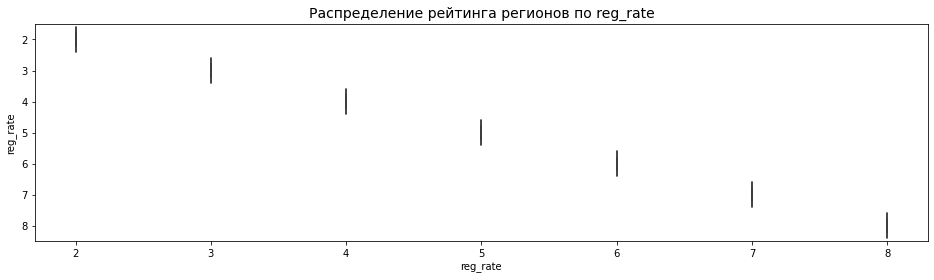

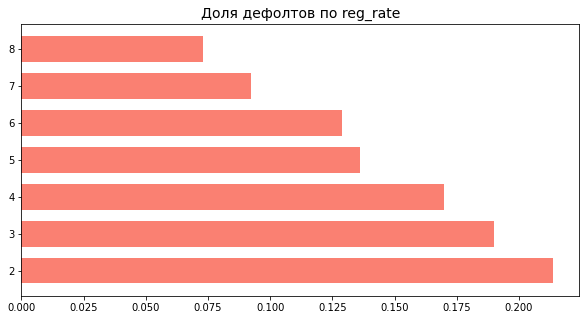

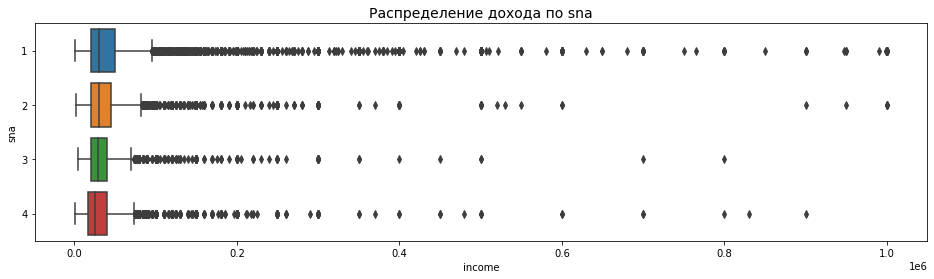

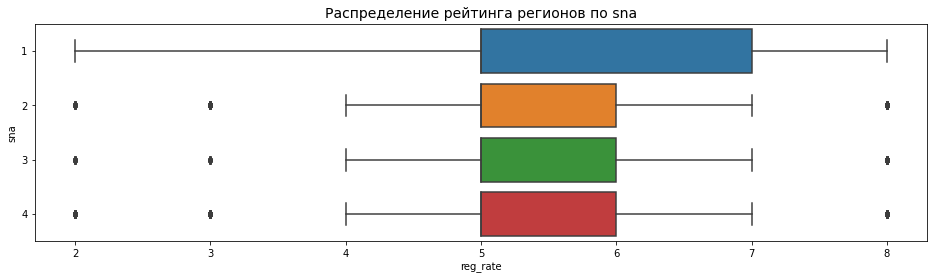

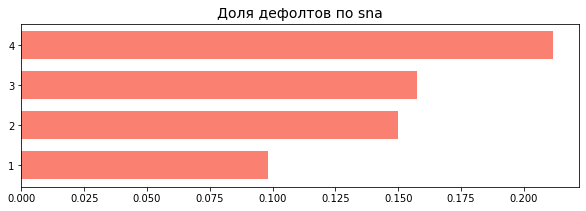

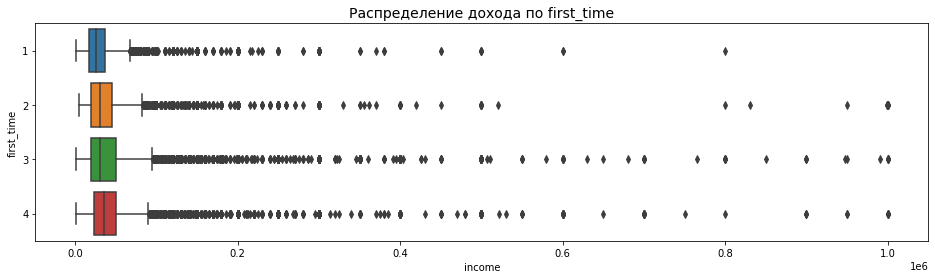

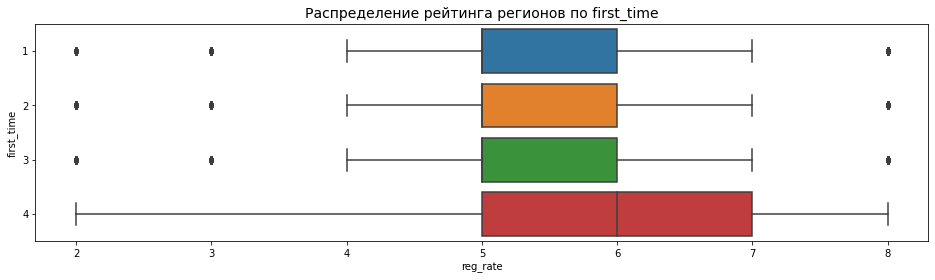

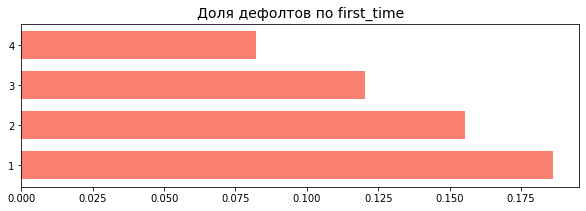

In [63]:
for cat in short_cat_cols:
    plt.figure(figsize = (16,4))
    sns.boxplot( y = cat, x = 'income', data=data, orient='h')
    plt.title('Распределение дохода по '+cat, fontsize=14)
    plt.show()

    plt.figure(figsize = (16,4))
    sns.boxplot( y = cat, x = 'reg_rate', data=data, orient='h')
    plt.title('Распределение рейтинга регионов по '+cat, fontsize=14)
    plt.show();

    mean_def_cat = dict()
    cats = list(data[cat].unique())
    for c in cats:
        popul = data.loc[data[cat] == c]['client_id'].count()
        num_def = data.loc[data[cat] == c]['default'].sum()
        mean_def_cat[c] = num_def / popul
    plt.figure(figsize=(10, (3 if len(cats) <5 else 5) ) )
    plt.barh(cats,[mean_def_cat[c] for c in cats], height=0.7, color = 'salmon')
    plt.title('Доля дефолтов по '+ cat, fontsize =14)
    plt.show();

Можно заметить, что признаки first_time, sna, reg_rate, work_address, educ_cat имеют хорошую для обучения линейную зависимость.  А вот в признаке home_address можно сделать переупорядочивание категорий.

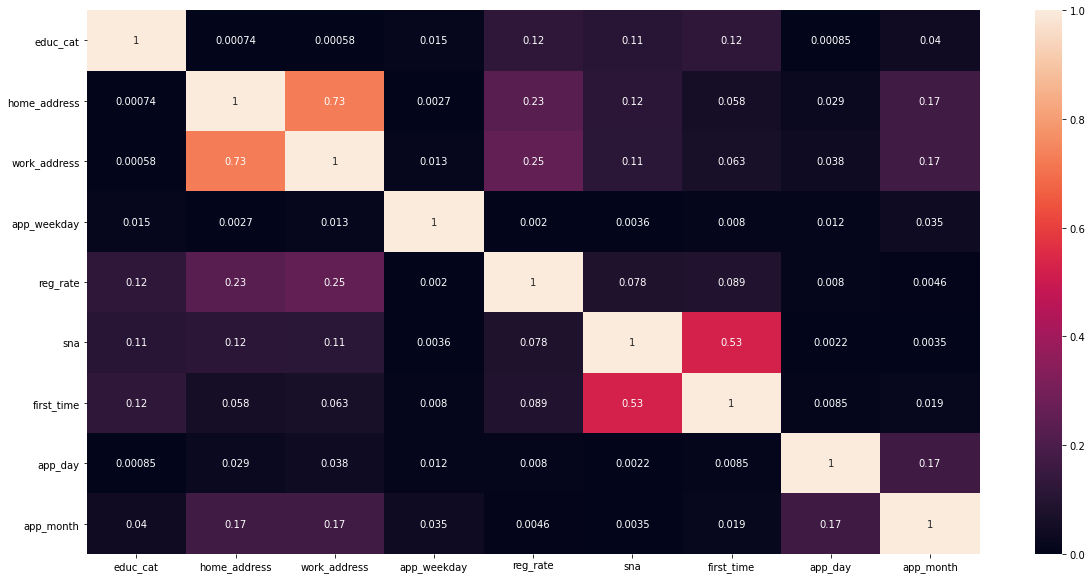

In [64]:
plt.figure(figsize=(20, 10))
sns.heatmap(data[cat_cols].corr().abs(), vmin=0, vmax=1, annot = True);

- Лица с высоким уровнем образования имеют в среднем чуть более высокий доход, живут в регионах с более высоким рейтингом и реже допускают дефолт.
- Лица с более длинной историей (высоким уровнем first_time) имеют чуть более высокий доход, и меньше допускают дефолтов.
- Лица с более длинной историей имеют больше связей с другими клиентами банка видимо сильно связаны с другими клиентами банка.
- Имеется корреляция признаков sna и first_time. Комбнирование с помощью PCA не очень уместно для категорий. Можно попробовать сделать признак дистанции между этими двумя признаками как модуль разности их значений.

- Дефолты чаще встречаются в регионах с низким рейтингом. Доходность кредитного портфеля не оптимизирована по регионам.

Люди с большим значением work_address допускают больше дефолтов. Есть взаимная корреляция с home_address. PCA опять не очень подходит - попробую сделать признак дистанции между двумя адресами.

### Анализ бинарных переменных

In [65]:
bin_cols = ['sex', 'car', 'car_type',  'good_work', 'foreign_passport']

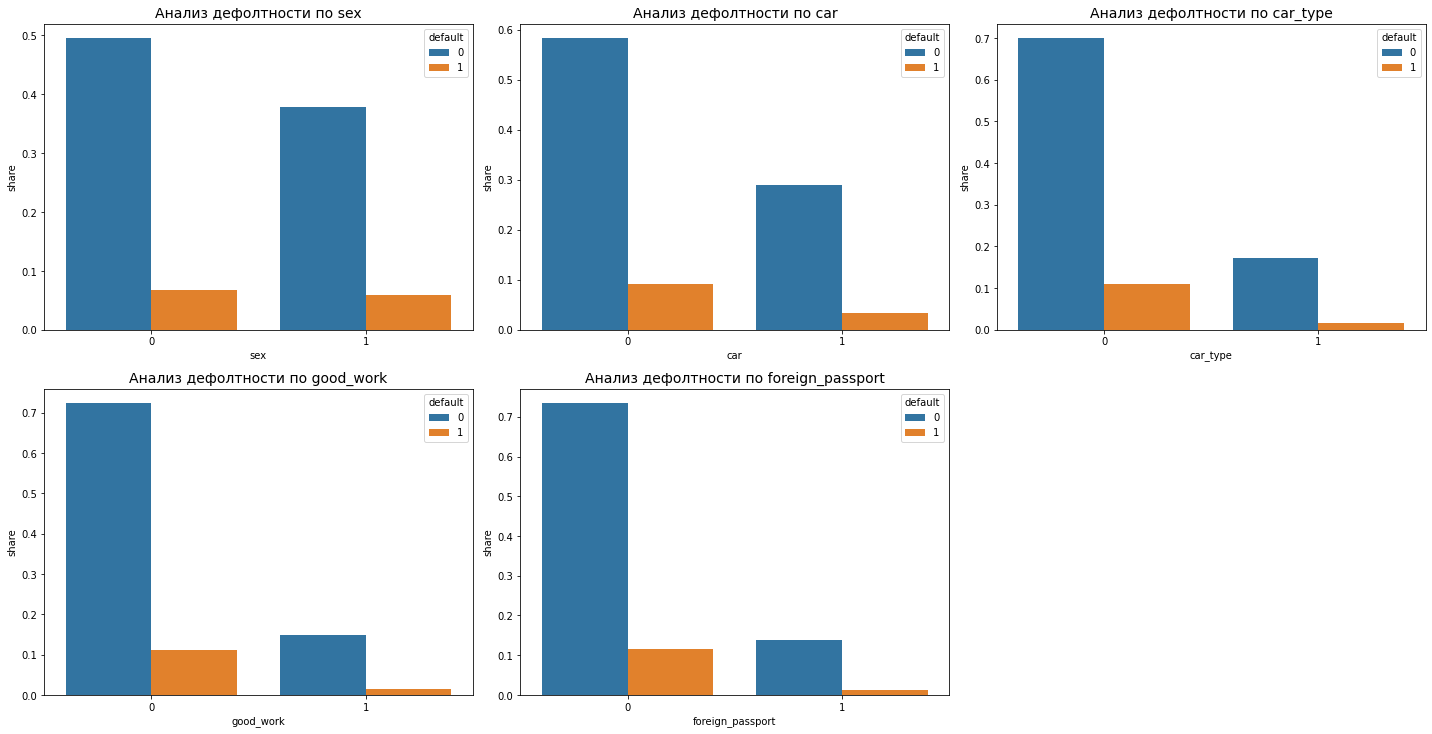

In [66]:
plt.figure(figsize=[20, 20])
i = 1

for c in bin_cols:
    plt.subplot(4, 3, i)
    sns.barplot(
        x=c,
        y='share',
        hue='default',
        data=data[[c, 'default']].value_counts(normalize=True).rename('share').reset_index()
    )
    plt.title('Анализ дефолтности по ' + c, fontsize=14)
    i += 1
plt.tight_layout()
plt.show();

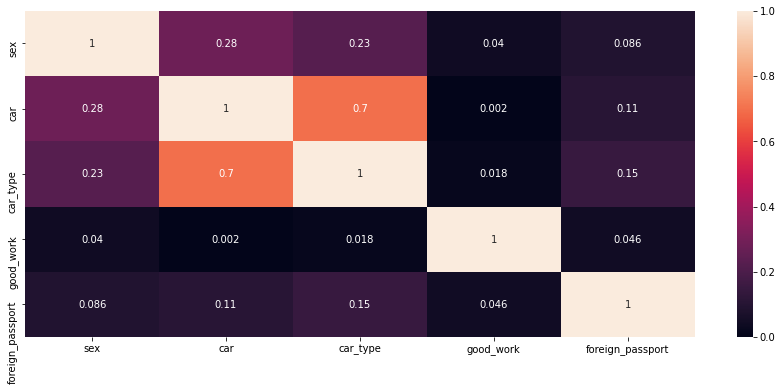

In [67]:
plt.figure(figsize=(15, 6))
sns.heatmap(data[bin_cols].corr().abs(), vmin=0, vmax=1, annot = True);

Женщин среди клиентов банка больше, а доля дефолтов примерно совпадает с мужчинами.
Наличие автомобиля и его иностранная марка снижают вероятность дефолта. Вероятно, есть смысл объединить наличие и инстранную марку автомобиля в один категорийный признак.
Наличие хорошей работы (справки НДФЛ?) и загранпаспорта снижает вероятность дефолта.

### Анализ значимости

In [68]:
data.columns

Index(['client_id', 'app_date', 'education', 'sex', 'age', 'car', 'car_type',
       'decline_app_cnt', 'good_work', 'score_bki', 'bki_request_cnt',
       'home_address', 'work_address', 'income', 'sna', 'first_time',
       'foreign_passport', 'default', 'app_weekday', 'app_day', 'app_month',
       'educ_cat', 'reg_rate'],
      dtype='object')

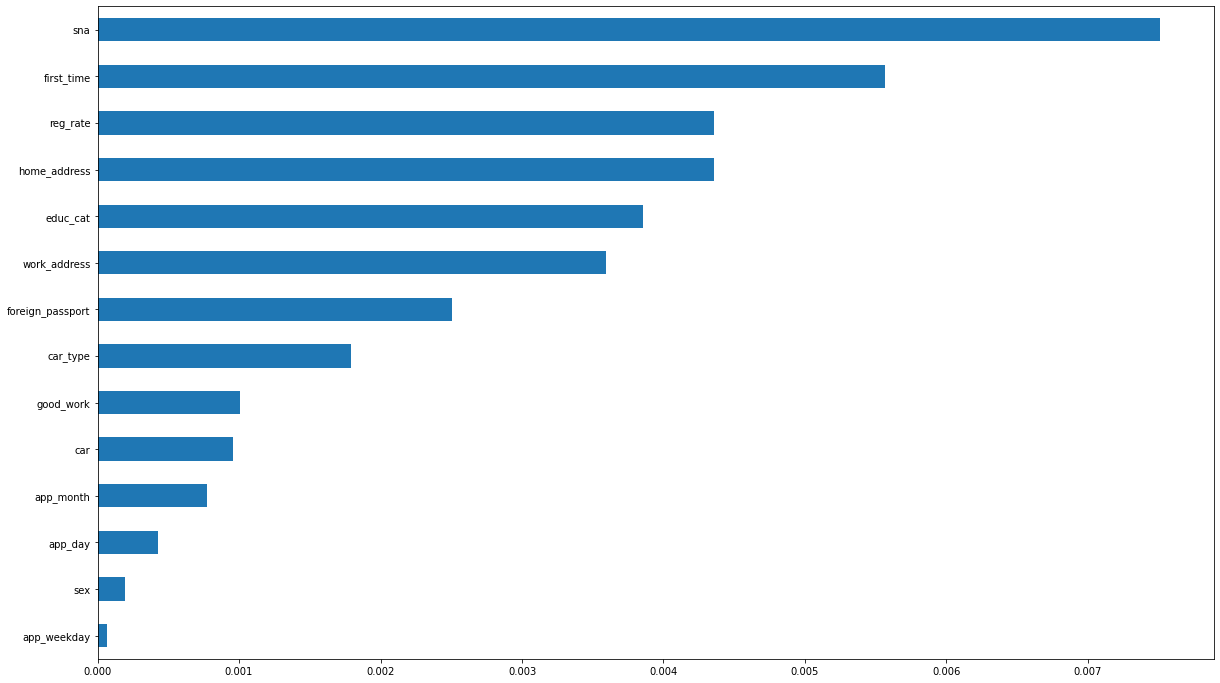

In [69]:
bin_cat_cols = bin_cols + cat_cols
plt.figure(figsize=(20, 12))
imp_cat = Series(mutual_info_classif(data[bin_cat_cols], data['default'], discrete_features =True), index = bin_cat_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh');

Признак дня недели влияет на результат меньше всего.  Вероятно у банка розничная модель без POS кредитования и нет импульсивных кредитов под покупки. Возможно есть смысл в дальнейшем удалить день (недели) подачи заявки и пол заемщика.

Еще один анализ значимости но всех коэффициентов с параметром discrete_features = 'auto' (автоматическим выбором типа признака).

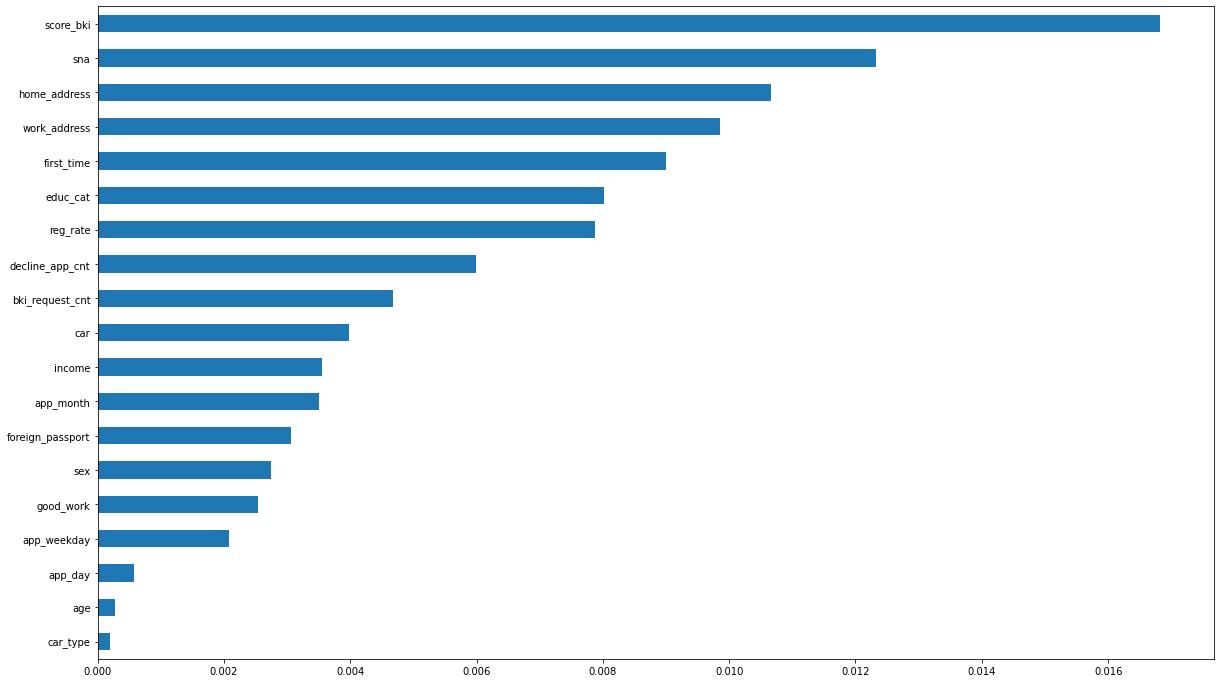

In [70]:
# Еще один подход к оценке важности всех признаков
feat_cols = ['sex', 'age', 'car', 'car_type', 'decline_app_cnt', 'good_work', 'score_bki', 'bki_request_cnt', 'home_address', 'work_address', 'income', 'sna', 'first_time', 'foreign_passport', 'app_weekday', 'app_day', 'app_month',  'educ_cat', 'reg_rate']
plt.figure(figsize=(20, 12))
imp_cat = Series(mutual_info_classif(data[feat_cols], data['default']), index = feat_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh');

Выводы:
- В банке отсутствует дискриминация по возрасту но возраст заемщика похоже наименее значим сам по себе.
- Явно не очень информативны и дата подачи заявки (от начала наблюдений) и день (месяца) подачи заявки.
- mutual_info_classif в явном виде зависит от случайного числа random_state. Возможно необходимо фиксировать это число или вводить какое-то усреднение

## Наивная модель - бенчмарк

Для наивного моделирования использован набор различных классификаторов с настройками по умолчанию и использованием, где это возможно, всех процессоров. Я решил задокументировать результаты моделирования для последующего сравнения.

In [71]:
model_eval = dict()

In [72]:
 # Все модели
 list_models = [ 'LogReg', 'DecTree', 'ExtTree', 'AdaBst', 'Bagg', 'ExtEns', 'GradBst', 'RanFrst']


In [73]:
model_eval['EDA'] = eval_basic_models(data.drop(['client_id', 'app_date', 'education'],axis=1), 'None', list_models )
model_eval['EDA']

Model: LogReg, DecTree, ExtTree, AdaBst, Bagg, ExtEns, GradBst, RanFrst, done. 115.8467 sec


,LogReg,DecTree,ExtTree,AdaBst,Bagg,ExtEns,GradBst,RanFrst
Recall,0.00736,0.22780,0.20552,0.03288,0.05432,0.01878,0.02464,0.01826
Selectivity,0.99830,0.86022,0.87642,0.99394,0.98242,0.99502,0.99602,0.99674
FNR,0.99264,0.77220,0.79448,0.96712,0.94568,0.98122,0.97536,0.98174
FPR,0.00170,0.13978,0.12358,0.00606,0.01758,0.00498,0.00398,0.00326
Bal.Error,0.49716,0.45598,0.45904,0.48660,0.48160,0.49308,0.48964,0.49250
AUCROC,0.65706,0.54402,0.54096,0.73296,0.64288,0.69866,0.73604,0.70754
f1-score,0.01428,0.20810,0.19998,0.06118,0.09238,0.03564,0.04686,0.03504
MCC,0.03266,0.08188,0.08010,0.09238,0.08290,0.05616,0.08534,0.06974


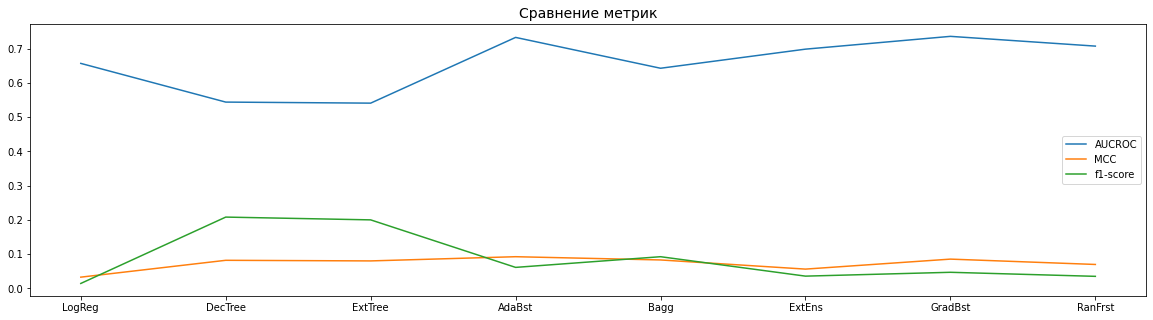

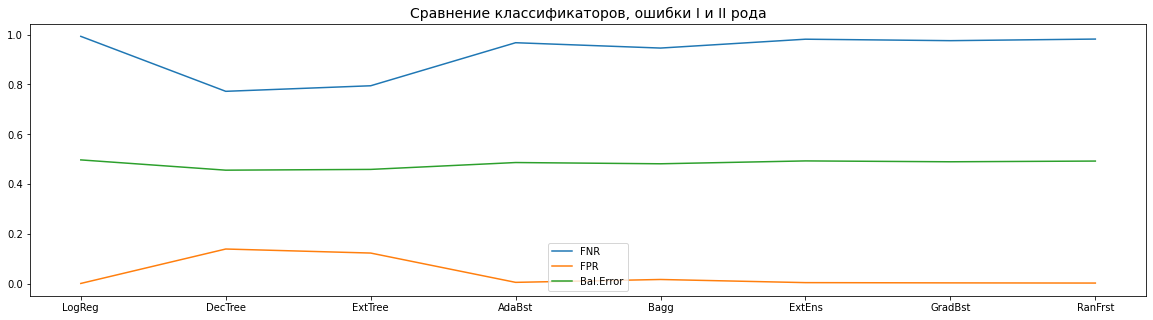

In [74]:
# compare_models_bar(model_eval['EDA'],'AUCROC','Сравнение классификаторов, AUCROC')
# compare_models_bar(model_eval['EDA'],'MCC','Сравнение классификаторов, MCC')
compare_models_plot(model_eval['EDA'], ['AUCROC', 'MCC', 'f1-score'],'Сравнение метрик')
compare_models_plot(model_eval['EDA'], ['FNR', 'FPR', 'Bal.Error'],'Сравнение классификаторов, ошибки I и II рода')

В соответствии с предложенной метрикой (ROC AUC) результаты простых классификаторов (LogisticRegression, DecisionTreeClassifier, ExtraTreeClassifier) оказалось значительно хуже (ROC AUC в пределах 0.53-0.59), чем результаты ансамблей и специализированных моделей (результаты ROC_AUC в пределах 0.63-0.75 для AdaBoostClassifier(), BaggingClassifier(), ExtraTreesClassifier(), GradientBoostingClassifier(), RandomForestClassifier()).

Предложенный по условиям показатель AUCROC унаследован от символьных времен WWII, и (возможно) не отражает реальной бизнес-потребности кредитного скоринга. Другие известные показатели тоже ориентированы на максимизацию. В задаче кредитного скоринга представляется более важным минимизировать ошибки I и II рода. Соответственно, по аналогии с показателем Balanced Accuracy предложен показатель Balanced Error = (FNR + FPR)/2, который также надо минимизировать. По этому показателю лидерами в "наивном зачете" становтся DecisionTreeClassifier и Extra Tree Classifier, отличающиеся минимумом FNR (минимум одобрения кредитных заявок для дефолтных клиентов).

К сожалению вариант матрицы конфуза не очень применим  из-за его низкой понятности на графиках.

Библиотека scikit-learn разработала и внедряет подход построения конвейера для решения задач машинного обучения. Для конвейера реализованы не все метрики, ме любопытно сравнить поведение f1-score и Balanced Error. Желательно понаблюдать - возможно ли обойтись, например, f1-score для несбалансированных классов.

Данные в исходном наборе несбалансированы. Это может оказать существенное влияние на качество модели. Были изучены и включены в моделирование три алгоритма дополнения данных до баланса - случайное дополнение и два более сложных SMOTE и ADASYN. Они взяты из библиотеки imbalance learning, которая фигурирует как кандидат на включение в scikit learn.

В литературе найдено утверждение, что наиболее мощным алгоритмом учета небаланса классов является выбор порогового значения для финальной классификации.  Намереваюсь проверить этот тезис позже.


In [75]:
oversamplers = ['RanOS','SMOTE','ADASYN']
for os in oversamplers:
    label = 'EDA+'+os
    model_eval[label] = eval_basic_models(data.drop(['client_id', 'app_date', 'education'],axis=1), os, list_models)
    # model_eval[label]

Model: LogReg, DecTree, ExtTree, AdaBst, Bagg, ExtEns, GradBst, RanFrst, done. 186.5352 sec
Model: LogReg, DecTree, ExtTree, AdaBst, Bagg, ExtEns, GradBst, RanFrst, done. 349.9599 sec
Model: LogReg, DecTree, ExtTree, AdaBst, Bagg, ExtEns, GradBst, RanFrst, done. 763.1696 sec


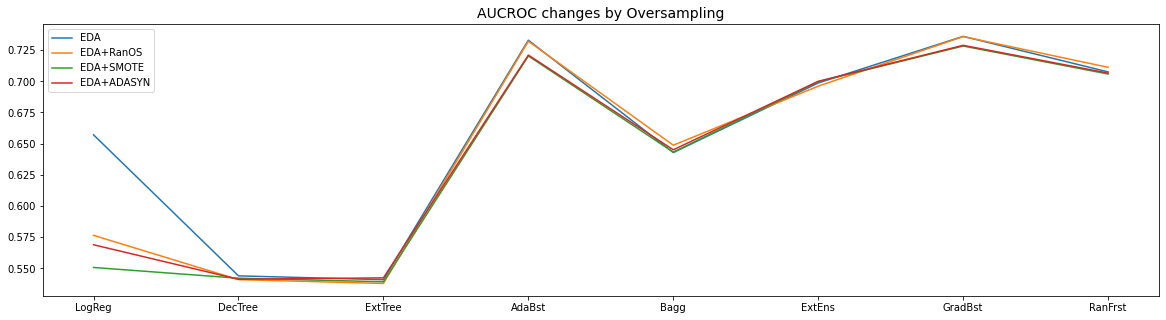

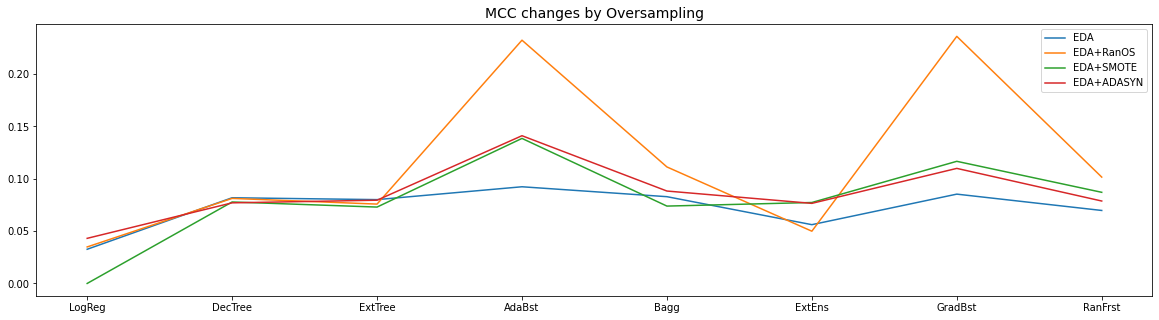

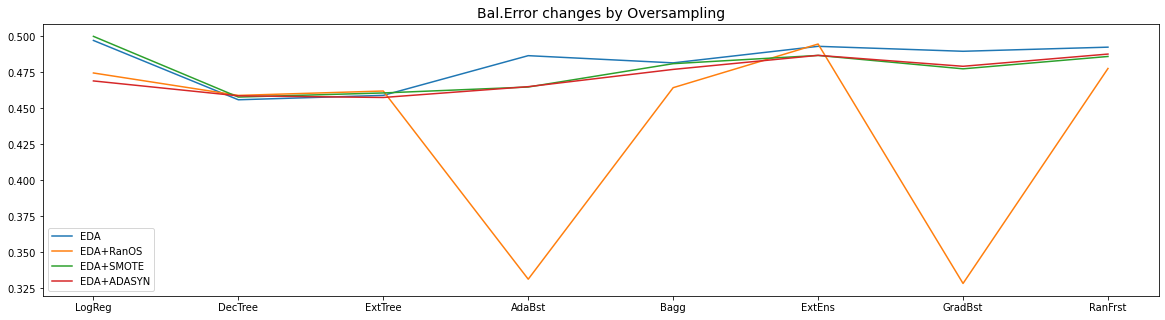

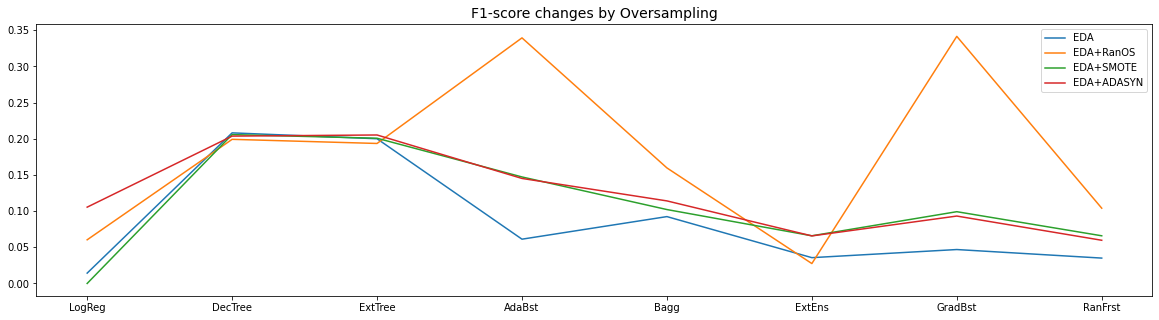

In [76]:
compare_scenarios_plot(model_eval,'AUCROC','AUCROC changes by Oversampling')
compare_scenarios_plot(model_eval,'MCC','MCC changes by Oversampling')
compare_scenarios_plot(model_eval,'Bal.Error','Bal.Error changes by Oversampling')
compare_scenarios_plot(model_eval,'f1-score','F1-score changes by Oversampling')


По результатам сравнения можно сформировать короткий список из трех-четырех моделей - LinearRegresstion, Decision Tree и два ансамбля - Ada и Gradient бустинги.  Также имеет смысл ограничиться только одним алгоритмом балансировки набора данных - использовать Random Oversampling.  Стандартная метрика f1-score пока довольно хорошо аппроксимирует Balanced Error.

Продолжение в следующей рабочей книге.
